In [11]:
import pandas as pd
from darts import TimeSeries
from darts.models.forecasting.random_forest import RandomForest
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [12]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [13]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [14]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    target_lags_list = [-i for i in range(1, 5)]
    params = {
        'n_estimators': 150,
        'max_depth': 18,
        'min_samples_split': 13,
        'min_samples_leaf': 13,
        'max_features': 0.5774519952255706,
        'bootstrap':False,
        'criterion':"squared_error",
        'min_weight_fraction_leaf': 0.0003584570012586107,
        'n_jobs': -1
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    scaler = scaler.fit(train_fold)
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    
    model = RandomForest(
        lags=target_lags_list,
        add_encoders=encoders,
        **params
    )

    model.fit(
        series=train_scaled,
        val_series=val_scaled,
    )
    
    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    20.987776    4.581242    3.577508  0.581788   
Precipitation_accumulated       0.788892    0.888196    0.411339 -0.273914   
Humidity                      277.247479   16.650750   13.172484  0.106858   
Wind_Speed_kmh                  0.610415    0.781291    0.654068 -0.463589   
Soil_Moisture              322390.419341  567.794346  363.610275  0.471071   
Soil_Temperature               25.680217    5.067565    3.945621  0.649697   
Wind_Dir_Sin                    0.259486    0.509398    0.428818  0.180865   
Wind_Dir_Cos                    0.351358    0.592755    0.494538  0.097475   

                                SMAPE  
Temperature                 22.120642  
Precipitation_accumulated   12.191892  
Humidity                    20.172909  
Wind_Speed_kmh              58.493193  
Soil_Mo

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                    14.100747    3.755096    2.567898  0.594058   
Precipitation_accumulated  145747.364714  381.768732  322.760957 -2.539583   
Humidity                      490.690296   22.151530   19.061873 -2.916654   
Wind_Speed_kmh                  1.355829    1.164401    1.000349 -3.019463   
Soil_Moisture              290496.118494  538.976918  448.749515  0.811686   
Soil_Temperature               16.721714    4.089219    2.945108  0.532250   
Wind_Dir_Sin                    0.292400    0.540740    0.441538 -0.213439   
Wind_Dir_Cos                    0.550260    0.741795    0.645810  0.172322   

                                SMAPE  
Temperature                 18.305447  
Precipitation_accumulated  154.756996  
Humidity                    26.546184  
Wind_Speed_kmh             130.440242  
Soil_Mo

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE        MAE            R2  \
Temperature                    8.814001    2.968838   2.526369 -5.063427e-01   
Precipitation_accumulated      7.074106    2.659719   2.274143 -5.573718e+04   
Humidity                      17.189593    4.146033   3.415637 -4.566063e-03   
Wind_Speed_kmh                 0.003517    0.059302   0.049657          -inf   
Soil_Moisture              12303.318767  110.920326  84.601864 -8.312964e+00   
Soil_Temperature               4.563024    2.136124   1.745489  3.070155e-01   
Wind_Dir_Sin                   0.000108    0.010402   0.007941          -inf   
Wind_Dir_Cos                   0.000272    0.016500   0.014228          -inf   

                                SMAPE  
Temperature                 16.367318  
Precipitation_accumulated    0.498067  
Humidity                     3.913512  
Wind_Speed_kmh             20

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     0.855663    0.925021    0.778333 -0.455337   
Precipitation_accumulated       0.200551    0.447829    0.303736 -5.109737   
Humidity                        9.293750    3.048565    2.407606  0.027393   
Wind_Speed_kmh                  0.000034    0.005833    0.001414      -inf   
Soil_Moisture              118096.196096  343.651271  288.372327 -2.199331   
Soil_Temperature                0.083858    0.289582    0.209344  0.654017   
Wind_Dir_Sin                    0.000003    0.001666    0.000393      -inf   
Wind_Dir_Cos                    0.000005    0.002264    0.000563      -inf   

                                SMAPE  
Temperature                  8.039456  
Precipitation_accumulated    0.066305  
Humidity                     2.659507  
Wind_Speed_kmh             200.000000  
Soil_Mo

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE         R2  \
Temperature                     7.319977    2.705546    2.010726  -2.073340   
Precipitation_accumulated       1.415702    1.189833    0.549580  -4.071573   
Humidity                       56.114654    7.490971    5.829967  -0.167455   
Wind_Speed_kmh                  0.022293    0.149309    0.052203  -9.985544   
Soil_Moisture              229451.295339  479.010747  248.245924 -28.141181   
Soil_Temperature                5.379899    2.319461    1.673220  -2.310147   
Wind_Dir_Sin                    0.014219    0.119242    0.039458   0.748663   
Wind_Dir_Cos                    0.022899    0.151324    0.049034   0.735027   

                                SMAPE  
Temperature                 25.811916  
Precipitation_accumulated    0.119845  
Humidity                     6.919001  
Wind_Speed_kmh             191.931301 

Specified past encoders in `add_encoders` at model creation but model does not accept past covariates. past encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE         R2  \
Temperature                1.192790e+01     3.453680     2.628032  -0.295586   
Precipitation_accumulated  1.810458e+01     4.254948     3.687019 -14.454001   
Humidity                   1.290902e+02    11.361789     9.168868  -0.108040   
Wind_Speed_kmh             2.289774e+00     1.513200     0.987866  -0.475359   
Soil_Moisture              2.961275e+06  1720.835571  1489.969820  -1.171138   
Soil_Temperature           1.818025e+01     4.263830     3.449116  -2.615655   
Wind_Dir_Sin               6.845658e-01     0.827385     0.550349  -0.422033   
Wind_Dir_Cos               3.367628e-01     0.580313     0.459232   0.295395   

                                SMAPE  
Temperature                 53.106654  
Precipitation_accumulated    0.802171  
Humidity                    10.177036  
Wind_Speed_kmh             12

In [15]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


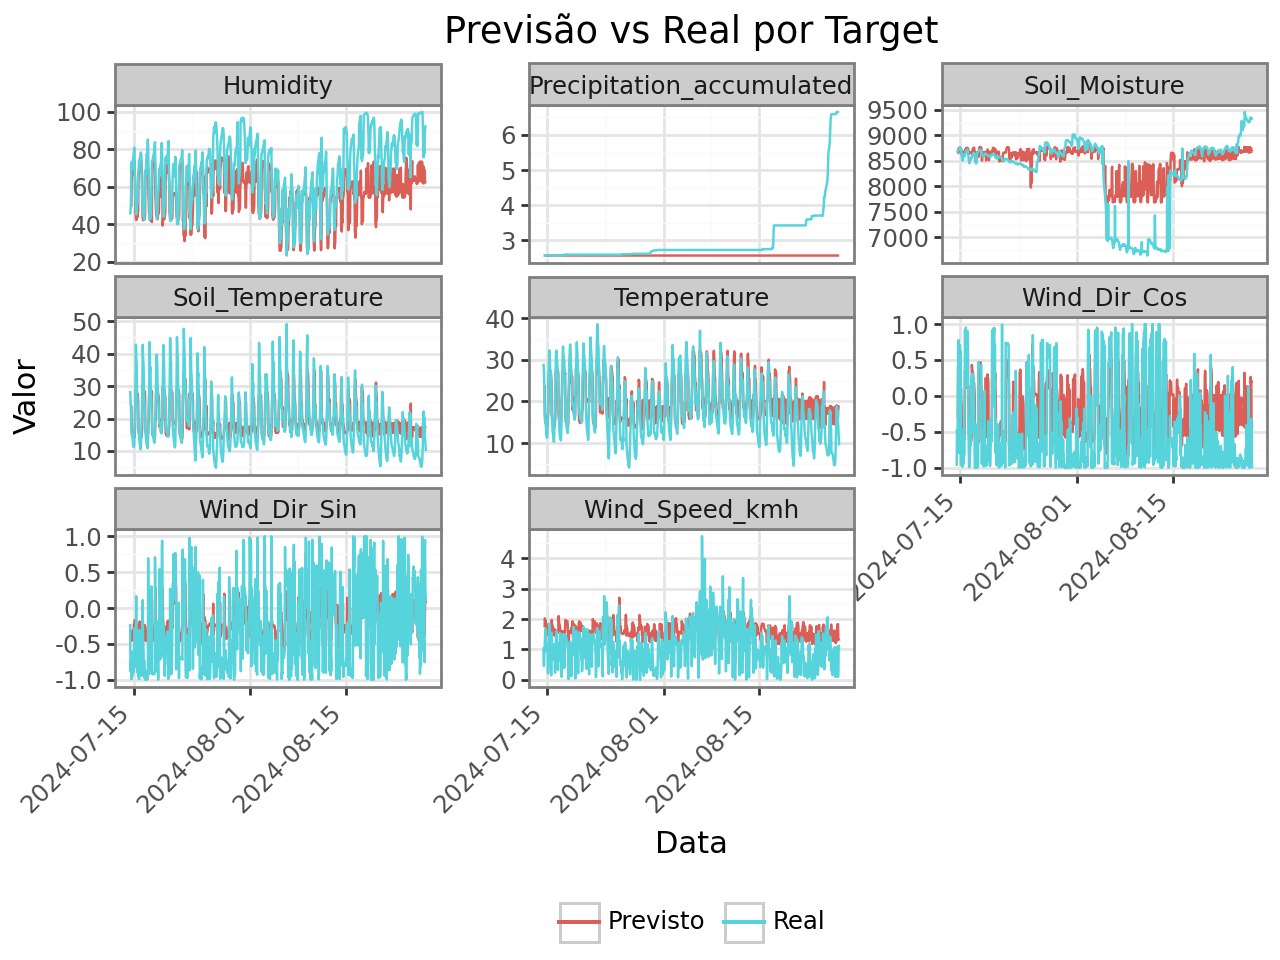

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_vs_real.png


In [16]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Real'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Previsto'

# Concatena os DataFrames 'Real' e 'Previsto'
df_combined = pd.concat([s_melted, forecasts_t_melted])

# Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão vs Real por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
    )
)
plot.show()
plot.save('previsao_vs_real.png', width=12, height=10, dpi=300)

In [17]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

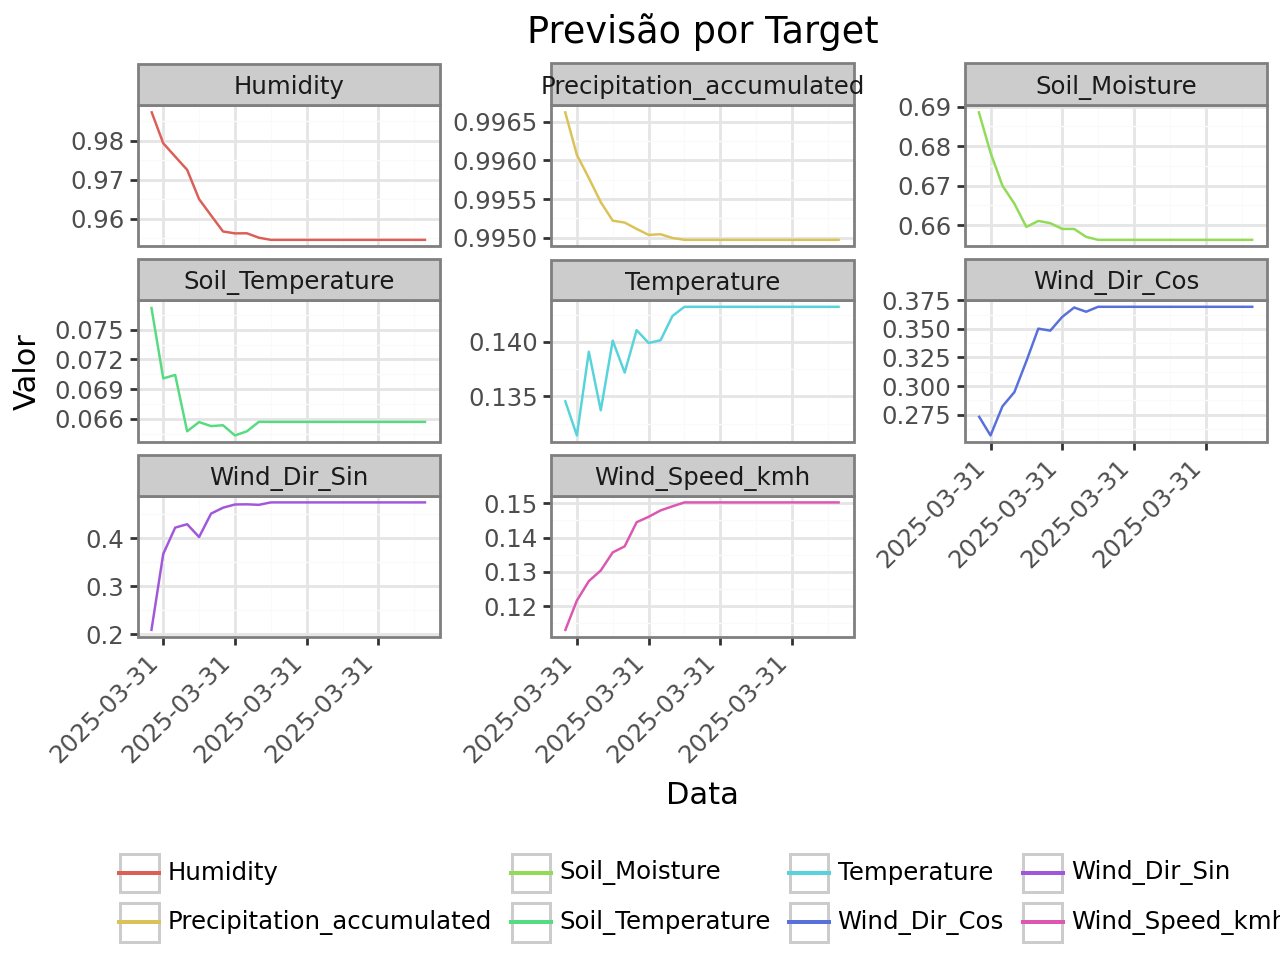

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: previsao_24_horas.png


In [18]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Previsão por Target',
        x='Data',
        y='Valor',
        color='Tipo de Dados' # Legenda para a cor
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotaciona os rótulos do eixo x
        legend_position='bottom', # Coloca a legenda na parte inferior
        legend_title=element_blank(), # Remove o título da legenda
        
    )
)
plot.show()
plot.save('previsao_24_horas.png', width=12, height=10, dpi=300)

In [19]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)